# **Modelos clásicos de series temporales**

## **1. Introducción al notebook**

En este notebook vamos a aplicar modelos clásicos de predicción en series temporales sobre un dataset real: **las temperaturas mínimas diarias en Melbourne (1981–1990)**.

Los modelos que trabajaremos son:

- Media móvil
- Regresión lineal
- ARIMA
- SARIMA

Nuestro objetivo es ver cómo cada modelo trata de capturar patrones temporales y predecir futuros valores.

## **2.  Carga y exploración del dataset**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cargar el dataset
df = pd.read_csv("../data/daily-min-temperatures.csv")  # Ajusta la ruta si es necesario
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Dividir datos: entrenamiento (1981–1989) y test (1990)
train = df[:'1989']
test = df['1990':]

# Visualizar primeras filas
print(df.head())

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


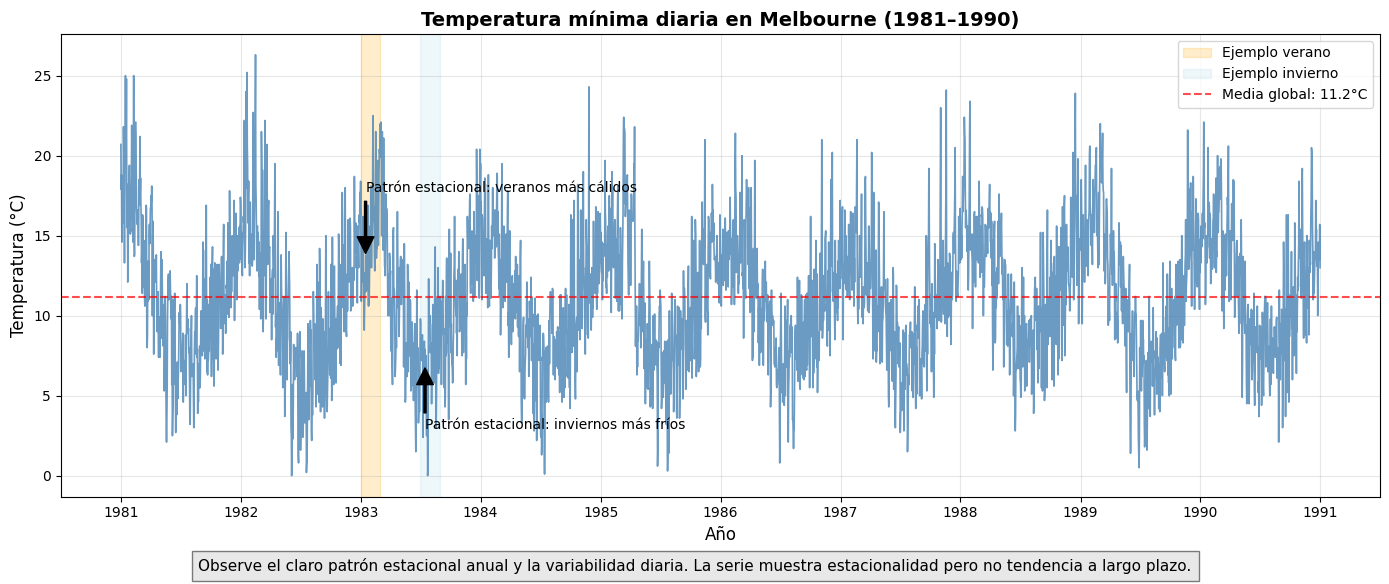

In [34]:
plt.figure(figsize=(14, 6))

# Graficar la serie completa
plt.plot(df['Temp'], color='steelblue', linewidth=1.2, alpha=0.8)

# Destacar patrones estacionales (ejemplo con años 1983 y 1984)
verano_1983 = df[(df.index >= '1983-01-01') & (df.index <= '1983-02-28')].index
invierno_1983 = df[(df.index >= '1983-07-01') & (df.index <= '1983-08-31')].index

# Añadir sombreados para resaltar estaciones
plt.axvspan(verano_1983[0], verano_1983[-1], alpha=0.2, color='orange', label='Ejemplo verano')
plt.axvspan(invierno_1983[0], invierno_1983[-1], alpha=0.2, color='lightblue', label='Ejemplo invierno')

# Añadir anotaciones para explicar patrones
plt.annotate('Patrón estacional: veranos más cálidos', 
             xy=(verano_1983[15], df.loc[verano_1983[15], 'Temp']+1), 
             xytext=(verano_1983[15], df.loc[verano_1983[15], 'Temp']+5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

plt.annotate('Patrón estacional: inviernos más fríos', 
             xy=(invierno_1983[15], df.loc[invierno_1983[15], 'Temp']-1), 
             xytext=(invierno_1983[15], df.loc[invierno_1983[15], 'Temp']-5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Mejorar eje X para mostrar años de manera más clara
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Añadir línea de tendencia (media global) para referencia
plt.axhline(y=df['Temp'].mean(), color='red', linestyle='--', alpha=0.7, 
            label=f'Media global: {df["Temp"].mean():.1f}°C')

# Mejorar elementos visuales
plt.title("Temperatura mínima diaria en Melbourne (1981–1990)", fontsize=14, fontweight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Añadir texto explicativo en la gráfica
plt.figtext(0.5, 0.01, 
            "Observe el claro patrón estacional anual y la variabilidad diaria. La serie muestra estacionalidad pero no tendencia a largo plazo.", 
            ha="center", fontsize=11, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Ajustar para el texto explicativo
plt.show()


## **3. Modelo de Media Móvil**

La media móvil es una forma sencilla de suavizar una serie temporal para resaltar patrones a largo plazo o tendencias.

A continuación aplicamos medias móviles de 7 y 30 días.


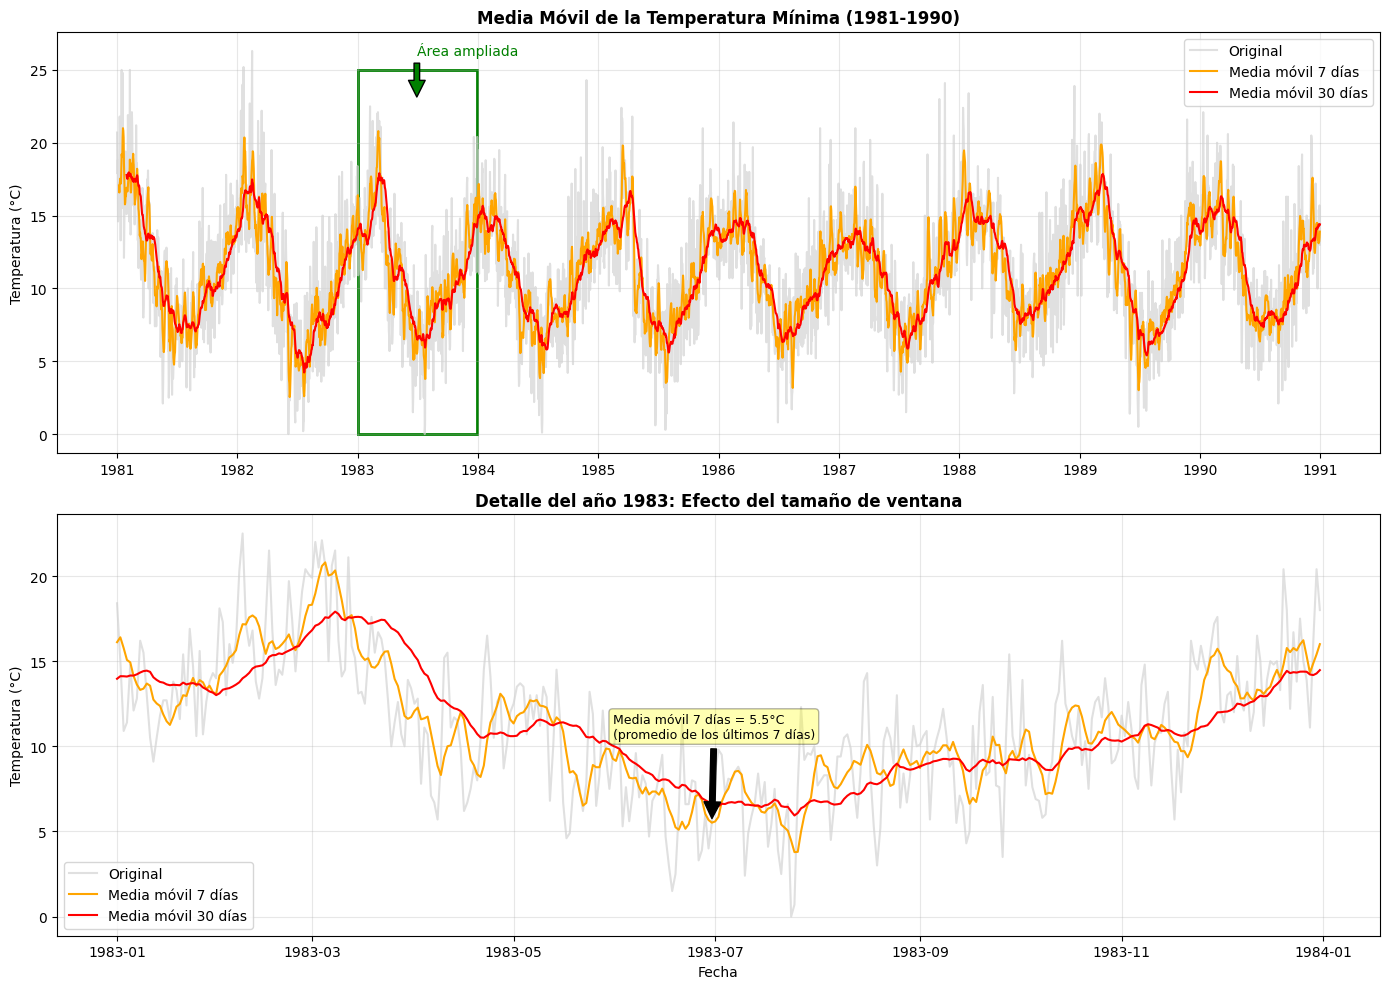

In [35]:
# Gráficos Media Móvil
df['MA_7'] = df['Temp'].rolling(window=7).mean()
df['MA_30'] = df['Temp'].rolling(window=30).mean()

# Seleccionamos un año específico para mostrar más detalle
año_muestra = df['1983-01-01':'1983-12-31'].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Gráfico de toda la serie
axes[0].plot(df['Temp'], label='Original', color='lightgray', alpha=0.7)
axes[0].plot(df['MA_7'], label='Media móvil 7 días', color='orange')
axes[0].plot(df['MA_30'], label='Media móvil 30 días', color='red')
axes[0].set_title("Media Móvil de la Temperatura Mínima (1981-1990)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Temperatura (°C)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Recuadro para destacar área ampliada
from matplotlib.patches import Rectangle
area_ampliada = Rectangle((mdates.date2num(año_muestra.index[0]), 0), 
                         mdates.date2num(año_muestra.index[-1]) - mdates.date2num(año_muestra.index[0]), 
                         25, fill=False, edgecolor='green', linewidth=2)
axes[0].add_patch(area_ampliada)
axes[0].annotate('Área ampliada', 
                xy=(mdates.date2num(año_muestra.index[180]), 23),
                xytext=(mdates.date2num(año_muestra.index[180]), 26),
                arrowprops=dict(facecolor='green', shrink=0.05),
                fontsize=10, color='green')

# Zoom del año 1983 para ver detalle
axes[1].plot(año_muestra['Temp'], label='Original', color='lightgray', alpha=0.7)
axes[1].plot(año_muestra['MA_7'], label='Media móvil 7 días', color='orange')
axes[1].plot(año_muestra['MA_30'], label='Media móvil 30 días', color='red')
axes[1].set_title("Detalle del año 1983: Efecto del tamaño de ventana", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("Temperatura (°C)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Mostrar ejemplo de cálculo para un día específico
fecha_ejemplo = año_muestra.index[180]  # Por ejemplo, un día en junio
valores_ventana = df['Temp'].loc[fecha_ejemplo - pd.Timedelta(days=6):fecha_ejemplo].values
promedio = valores_ventana.mean()

# Añadir anotación para explicar cálculo
axes[1].annotate(f'Media móvil 7 días = {promedio:.1f}°C\n(promedio de los últimos 7 días)',
                xy=(fecha_ejemplo, año_muestra.loc[fecha_ejemplo, 'MA_7']),
                xytext=(fecha_ejemplo - pd.Timedelta(days=30), año_muestra.loc[fecha_ejemplo, 'MA_7'] + 5),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()
plt.show()


## **4. Regresión Lineal sobre el tiempo**

Aplicamos una regresión lineal donde:
- X = número de días desde el inicio
- y = temperatura mínima diaria

Esto permite detectar tendencias lineales a lo largo del tiempo.


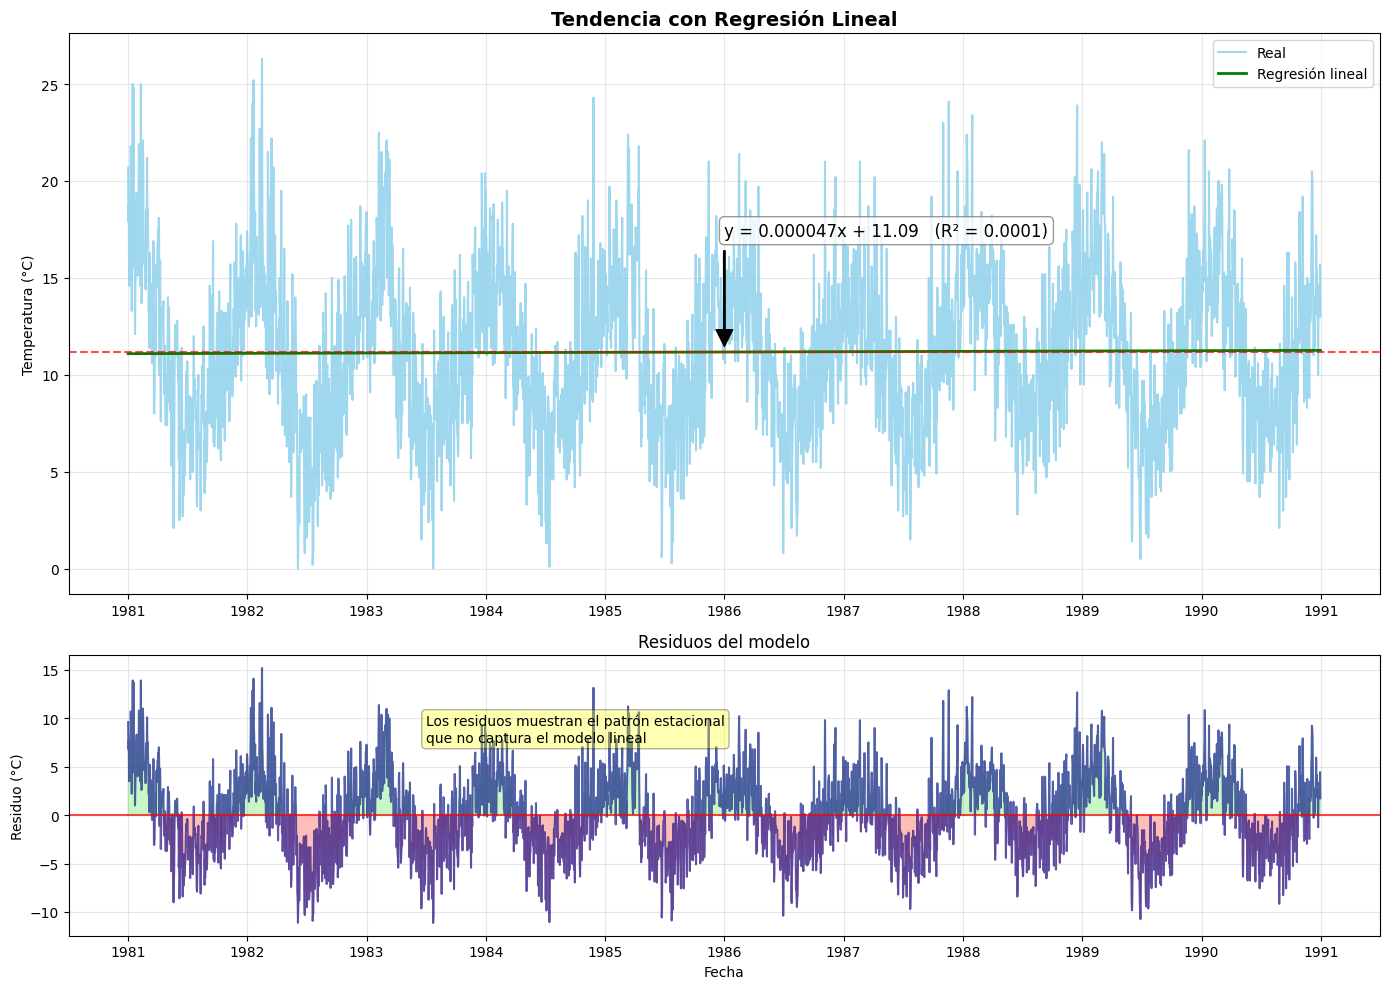

In [36]:
# Crear variable x (días desde el inicio)
days = np.arange(len(df))
X = days.reshape(-1, 1)
y = df['Temp'].values

# Ajustar modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir valores
predicted = model.predict(X)

# Calcular valores para mostrar en el gráfico
pendiente = model.coef_[0]
intercepto = model.intercept_
r2 = model.score(X, y)

# Crear figura con dos gráficos
fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Gráfico superior: Serie completa con regresión
axes[0].plot(df.index, df['Temp'], color='skyblue', label='Real', alpha=0.8)
axes[0].plot(df.index, predicted, color='green', label='Regresión lineal', linewidth=2)
axes[0].set_title("Tendencia con Regresión Lineal", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Temperatura (°C)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Añadir anotación con la ecuación y el R²
ecuacion = f'y = {pendiente:.6f}x + {intercepto:.2f}   (R² = {r2:.4f})'
axes[0].annotate(ecuacion, 
                xy=(df.index[len(df)//2], predicted[len(df)//2]),
                xytext=(df.index[len(df)//2], predicted[len(df)//2] + 6),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Añadir línea horizontal para la media
axes[0].axhline(y=df['Temp'].mean(), color='red', linestyle='--', alpha=0.7, 
            label=f'Media: {df["Temp"].mean():.2f}°C')

# Gráfico inferior: Residuos (diferencia entre valores reales y predichos)
residuos = df['Temp'].values - predicted
axes[1].plot(df.index, residuos, color='darkblue', alpha=0.6)
axes[1].axhline(y=0, color='red', linestyle='-', alpha=0.7)
axes[1].fill_between(df.index, residuos, 0, where=(residuos > 0), color='lightgreen', alpha=0.5)
axes[1].fill_between(df.index, residuos, 0, where=(residuos < 0), color='salmon', alpha=0.5)
axes[1].set_title("Residuos del modelo", fontsize=12)
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("Residuo (°C)")
axes[1].grid(True, alpha=0.3)

# Añadir texto explicativo
axes[1].annotate('Los residuos muestran el patrón estacional\nque no captura el modelo lineal',
                xy=(df.index[len(df)//4], max(residuos)/2),
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()
plt.show()

## **5. Modelo ARIMA**

El modelo ARIMA (AutoRegressive Integrated Moving Average) combina varios componentes para capturar la dinámica temporal de una serie.

### Funcionamiento:
- **AR**: Componente autoregresivo - el valor actual depende de valores anteriores.
- **I**: Componente integrado - aplica diferenciación para eliminar tendencias.
- **MA**: Componente de media móvil - incorpora errores de predicciones pasadas.

### Implementación:
- Utilizamos ARIMA(5,1,0) de `statsmodels`:
  - AR(5): Considera los 5 valores anteriores
  - I(1): Aplica una diferenciación de primer orden
  - MA(0): No utiliza componente de media móvil
- Entrenamos con datos de 1981-1989 (9 años).
- Predecimos las temperaturas de 1990 (1 año completo).

### Limitaciones:
- No captura adecuadamente patrones estacionales (ciclos anuales).
- Proporciona una predicción demasiado estable y horizontal.
- Aunque elimina tendencias, pierde información sobre patrones cíclicos.

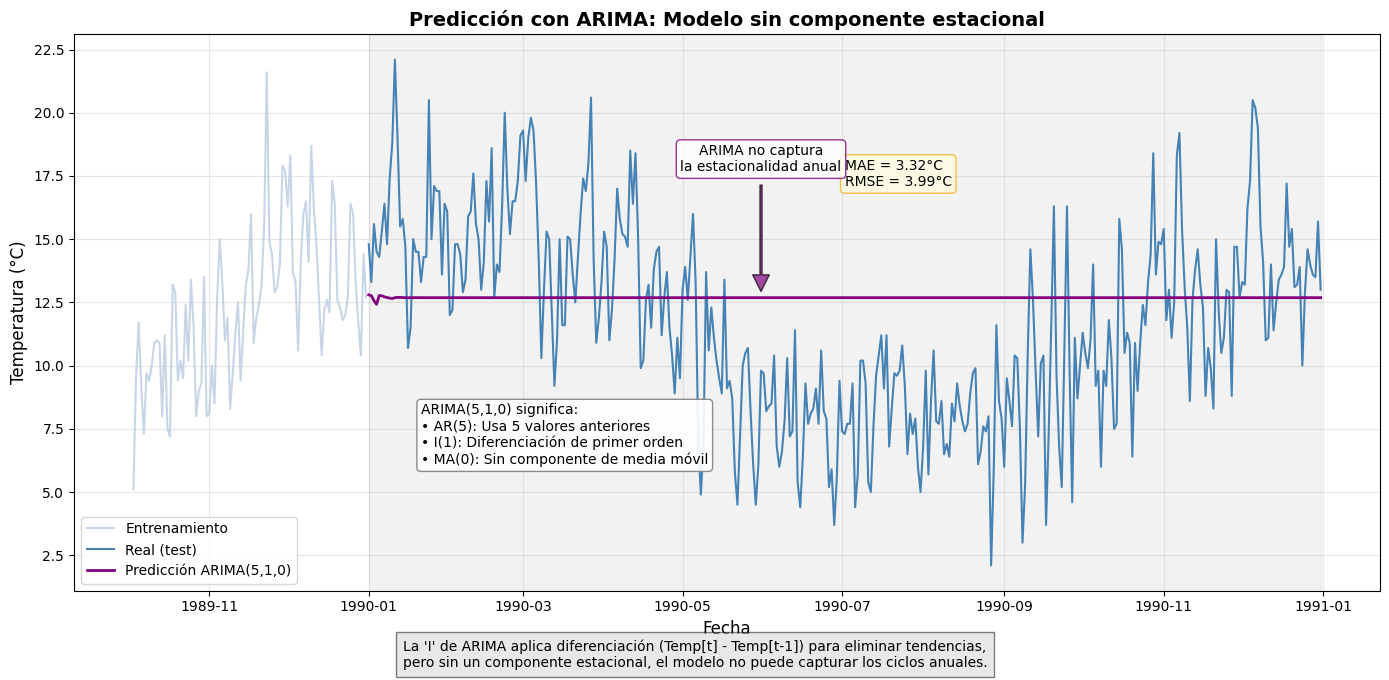

ARIMA(5,1,0) - MAE: 3.32°C, RMSE: 3.99°C


In [37]:
# Preparar datos para ARIMA
train_freq_arima = train.copy()
test_freq_arima = test.copy()

# Asegurarse de que no hay valores NaN
train_freq_arima = train_freq_arima.dropna()
test_freq_arima = test_freq_arima.dropna()

# Especificar frecuencia en el índice (diaria)
train_freq_arima.index = pd.DatetimeIndex(train_freq_arima.index).to_period('D')
test_freq_arima.index = pd.DatetimeIndex(test_freq_arima.index).to_period('D')

# Entrenar modelo ARIMA
arima_model = ARIMA(train_freq_arima['Temp'], order=(5, 1, 0))
arima_fit = arima_model.fit()

# Generar predicciones para el período de test
pred_start = len(train_freq_arima)
pred_end = pred_start + len(test_freq_arima) - 1
pred_arima = arima_fit.predict(start=pred_start, end=pred_end)

# Convertir los índices de predicción a las fechas correctas
pred_arima_series = pd.Series(pred_arima.values, index=test_freq_arima.index)

# Asegurarnos de que no hay NaN en las predicciones
if pred_arima_series.isna().any():
    pred_arima_series = pred_arima_series.fillna(method='bfill').fillna(method='ffill')

# Convertir índices para plotear
train_plot_arima = train_freq_arima.copy()
test_plot_arima = test_freq_arima.copy()
train_plot_arima.index = train_plot_arima.index.to_timestamp()
test_plot_arima.index = test_plot_arima.index.to_timestamp()
pred_arima_plot = pred_arima_series.copy()
pred_arima_plot.index = pred_arima_plot.index.to_timestamp()

# Calcular métricas de error
mae_arima = mean_absolute_error(test_plot_arima['Temp'], pred_arima_plot)
rmse_arima = np.sqrt(mean_squared_error(test_plot_arima['Temp'], pred_arima_plot))

# Visualizar resultados de ARIMA
plt.figure(figsize=(14, 7))

# Mostrar últimos 90 días de entrenamiento para contexto
context_start = train_plot_arima.index[-90]
plt.plot(train_plot_arima[train_plot_arima.index >= context_start].index,
        train_plot_arima[train_plot_arima.index >= context_start]['Temp'],
        label='Entrenamiento', color='lightsteelblue', alpha=0.7)

# Datos de test y predicción ARIMA
plt.plot(test_plot_arima.index, test_plot_arima['Temp'], label='Real (test)', color='steelblue', linewidth=1.5)
plt.plot(pred_arima_plot.index, pred_arima_plot, label='Predicción ARIMA(5,1,0)',
        color='purple', linewidth=2)

# Sombrear área de test
plt.axvspan(test_plot_arima.index[0], test_plot_arima.index[-1], alpha=0.1, color='gray')

# Anotaciones
plt.annotate('ARIMA(5,1,0) significa:\n• AR(5): Usa 5 valores anteriores\n• I(1): Diferenciación de primer orden\n• MA(0): Sin componente de media móvil',
            xy=(test_plot_arima.index[20], test_plot_arima['Temp'].min()+4),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.annotate(f'MAE = {mae_arima:.2f}°C\nRMSE = {rmse_arima:.2f}°C',
            xy=(test_plot_arima.index[len(test_plot_arima)//2], test_plot_arima['Temp'].max()-5),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.7))

# Anotar limitación de ARIMA
plt.annotate('ARIMA no captura\nla estacionalidad anual',
            xy=(test_plot_arima.index[150], pred_arima_plot.iloc[150]),
            xytext=(test_plot_arima.index[150], pred_arima_plot.iloc[150]+5),
            arrowprops=dict(facecolor='purple', shrink=0.05, width=1.5, alpha=0.7),
            fontsize=10, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", alpha=0.8))

# Mejorar aspecto visual
plt.title("Predicción con ARIMA: Modelo sin componente estacional", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Añadir explicación
plt.figtext(0.5, 0.01,
           "La 'I' de ARIMA aplica diferenciación (Temp[t] - Temp[t-1]) para eliminar tendencias,\npero sin un componente estacional, el modelo no puede capturar los ciclos anuales.",
           ha="center", fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

print(f"ARIMA(5,1,0) - MAE: {mae_arima:.2f}°C, RMSE: {rmse_arima:.2f}°C")

## **6. Modelo con Componente Estacional**

El modelo estacional extiende los conceptos del ARIMA para capturar patrones cíclicos regulares en los datos.

### Componentes del modelo:
- **Base autoregresiva**: Captura dependencias a corto plazo
- **Diferenciación**: Elimina tendencias para hacer la serie estacionaria
- **Componente estacional**: Incorpora explícitamente patrones que se repiten a intervalos fijos (365 días)

### Ventajas clave:
- Captura tanto la dinámica a corto plazo como los ciclos anuales de temperatura
- Permite modelar la estacionalidad inherente a fenómenos naturales como la temperatura
- Produce predicciones que siguen los patrones climáticos esperados

### Implementación:
- Combinamos un modelo ARIMA con patrones estacionales extraídos de los datos
- Entrenamos con datos de 1981-1989 y predecimos 1990 completo
- Esto demuestra cómo los modelos clásicos pueden adaptarse para capturar comportamientos cíclicos

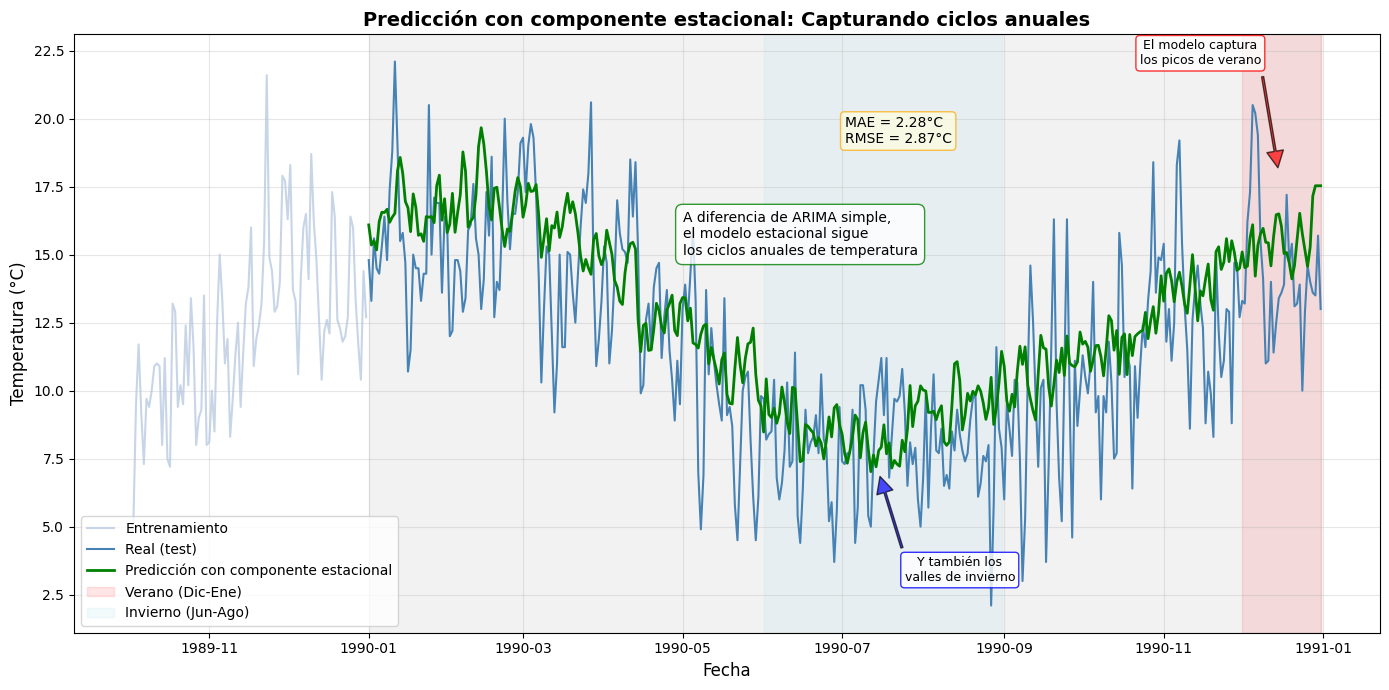

In [38]:
# Visualización del modelo estacional
plt.figure(figsize=(14, 7))

# Mostrar últimos 90 días de entrenamiento para contexto
context_start = train_plot.index[-90]
plt.plot(train_plot[train_plot.index >= context_start].index,
        train_plot[train_plot.index >= context_start]['Temp'],
        label='Entrenamiento', color='lightsteelblue', alpha=0.7)

# Datos de test y predicción estacional
plt.plot(test_plot.index, test_plot['Temp'], label='Real (test)', color='steelblue', linewidth=1.5)
plt.plot(pred_estacional_plot.index, pred_estacional_plot, label='Predicción con componente estacional',
        color='green', linewidth=2)

# Sombrear área de test
plt.axvspan(test_plot.index[0], test_plot.index[-1], alpha=0.1, color='gray')

# Sombrear áreas de verano e invierno para destacar estacionalidad
summer_start = pd.Timestamp('1990-12-01')
summer_end = pd.Timestamp('1991-01-31')
if summer_start <= test_plot.index[-1] and summer_end >= test_plot.index[0]:
    plt.axvspan(max(summer_start, test_plot.index[0]), 
               min(summer_end, test_plot.index[-1]), 
               alpha=0.1, color='red', label='Verano (Dic-Ene)')

winter_start = pd.Timestamp('1990-06-01')
winter_end = pd.Timestamp('1990-08-31')
plt.axvspan(winter_start, winter_end, alpha=0.1, color='skyblue', label='Invierno (Jun-Ago)')

# Anotaciones
plt.annotate(f'MAE = {mae_estacional:.2f}°C\nRMSE = {rmse_estacional:.2f}°C',
            xy=(test_plot.index[len(test_plot)//2], test_plot['Temp'].max()-3),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.7))

# Destacar patrones estacionales
plt.annotate('El modelo captura\nlos picos de verano',
            xy=(pd.Timestamp('1990-12-15'), 18),
            xytext=(pd.Timestamp('1990-11-15'), 22),
            arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, alpha=0.7),
            fontsize=9, ha='center', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

plt.annotate('Y también los\nvalles de invierno',
            xy=(pd.Timestamp('1990-07-15'), 7),
            xytext=(pd.Timestamp('1990-08-15'), 3),
            arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5, alpha=0.7),
            fontsize=9, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8))

# Comparación con enfoque tradicional
plt.annotate('A diferencia de ARIMA simple,\nel modelo estacional sigue\nlos ciclos anuales de temperatura',
            xy=(pd.Timestamp('1990-05-01'), 15),
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="green", alpha=0.8))

# Mejorar aspecto visual
plt.title("Predicción con componente estacional: Capturando ciclos anuales", fontsize=14, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.legend(loc='lower left')  # Cambiado a la esquina inferior izquierda
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **7. Comparación de modelos**

Comparamos las predicciones de AR y ARIMA con las observaciones reales usando:

- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)


AR - MAE: 2.99°C, RMSE: 3.63°C
Estacional - MAE: 2.28°C, RMSE: 2.87°C


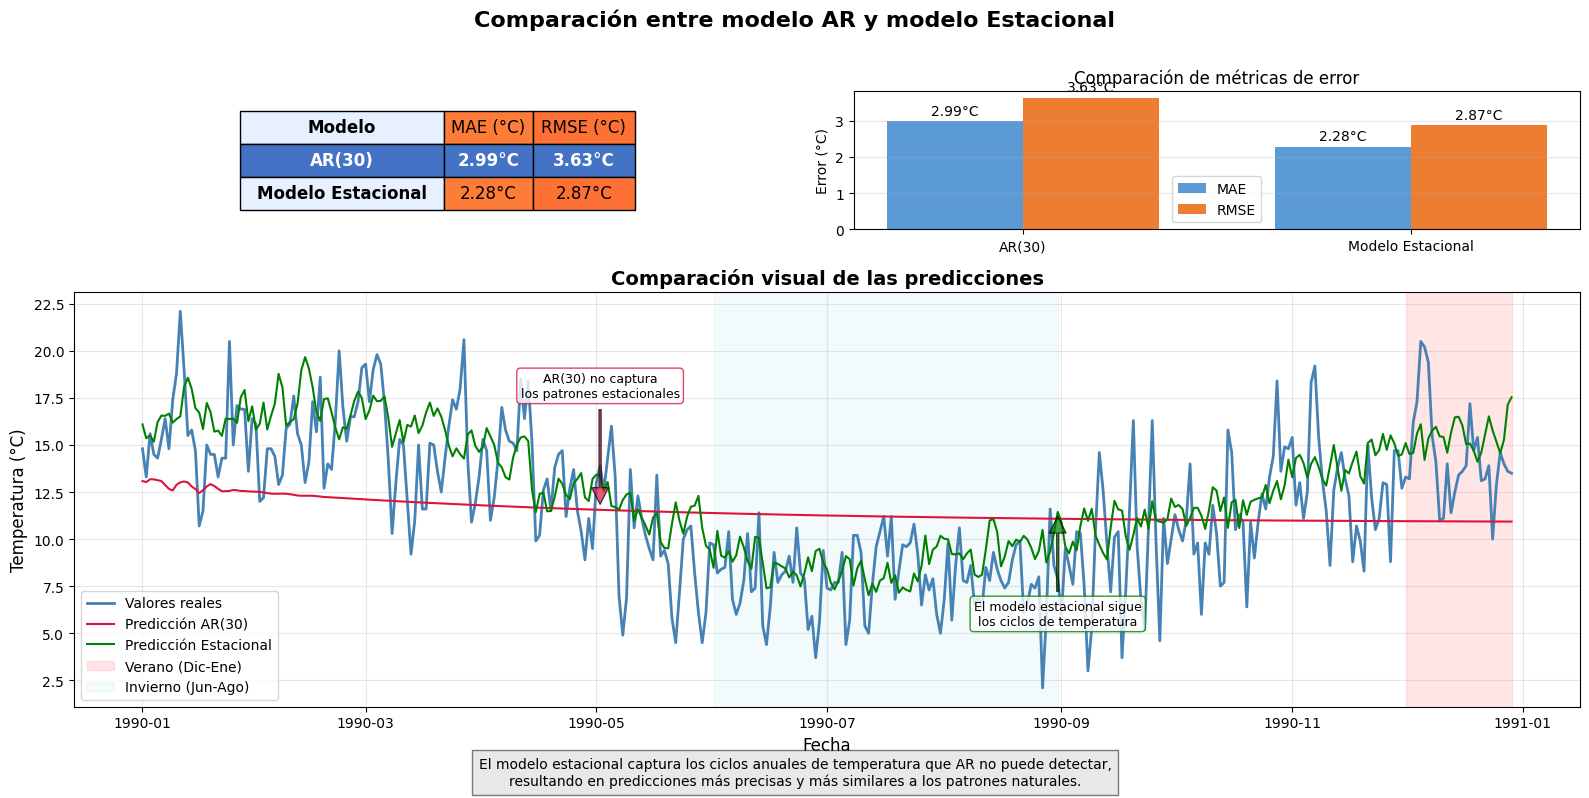

In [40]:
# Asegurarnos de que no hay NaN en las predicciones antes de calcular las métricas
def calcular_metricas_sin_nan(y_true, y_pred):
    # Convertir a series de pandas si no lo son ya
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Encontrar índices comunes que no son NaN
    common_idx = y_true.index.intersection(y_pred.index)
    valid_idx = common_idx[~pd.isna(y_true.loc[common_idx]) & ~pd.isna(y_pred.loc[common_idx])]
    
    if len(valid_idx) == 0:
        return np.nan, np.nan  # Devuelve NaN si no hay datos válidos
    
    # Calcular métricas solo en datos válidos
    mae = mean_absolute_error(y_true.loc[valid_idx], y_pred.loc[valid_idx])
    rmse = np.sqrt(mean_squared_error(y_true.loc[valid_idx], y_pred.loc[valid_idx]))
    
    return mae, rmse

# Calcular métricas (manejo robusto de NaN)
mae_ar, rmse_ar = calcular_metricas_sin_nan(test_plot_ar['Temp'], pred_ar_plot)
mae_estacional, rmse_estacional = calcular_metricas_sin_nan(test_plot['Temp'], pred_estacional_plot)

# Verificar que las métricas se calcularon correctamente
print(f"AR - MAE: {mae_ar:.2f}°C, RMSE: {rmse_ar:.2f}°C")
print(f"Estacional - MAE: {mae_estacional:.2f}°C, RMSE: {rmse_estacional:.2f}°C")

# Crear un DataFrame para visualizar
results_df = pd.DataFrame({
    'Modelo': ['AR(30)', 'Modelo Estacional'],
    'MAE': [mae_ar, mae_estacional],
    'RMSE': [rmse_ar, rmse_estacional]
})

# Crear figura con subplots
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 3])

# 1. Tabla estilizada (arriba a la izquierda)
ax_table = fig.add_subplot(gs[0, :2])
ax_table.axis('tight')
ax_table.axis('off')

# Crear tabla con estilo
cell_text = [[model, f"{mae:.2f}°C", f"{rmse:.2f}°C"] 
             for model, mae, rmse in zip(results_df['Modelo'], results_df['MAE'], results_df['RMSE'])]
table = ax_table.table(cellText=cell_text, 
                      colLabels=['Modelo', 'MAE (°C)', 'RMSE (°C)'],
                      loc='center', 
                      cellLoc='center',
                      colWidths=[0.3, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Personalizar apariencia de la tabla
table.auto_set_column_width([0, 1, 2])
for i, key in enumerate(table._cells):
    cell = table._cells[key]
    if i < 3:  # Encabezados
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4472C4')
    elif key[1] == 0:  # Nombres de los modelos
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E6F0FF')
    else:  # Valores
        if key[1] == 1:  # MAE
            # Color más intenso para errores mayores
            intensity = results_df['MAE'].iloc[key[0]-1] / results_df['MAE'].max()
            cell.set_facecolor(plt.cm.YlOrRd(intensity * 0.7))
        elif key[1] == 2:  # RMSE
            intensity = results_df['RMSE'].iloc[key[0]-1] / results_df['RMSE'].max()
            cell.set_facecolor(plt.cm.YlOrRd(intensity * 0.7))

# 2. Gráfico de barras (arriba a la derecha)
ax_bars = fig.add_subplot(gs[0, 2:])
bar_width = 0.35
x = np.arange(2)
metrics_bars = ax_bars.bar(x - bar_width/2, results_df['MAE'], bar_width, label='MAE', color='#5B9BD5')
metrics_bars2 = ax_bars.bar(x + bar_width/2, results_df['RMSE'], bar_width, label='RMSE', color='#ED7D31')

# Añadir etiquetas de valor
for bar in metrics_bars:
    height = bar.get_height()
    ax_bars.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}°C', ha='center', va='bottom')
for bar in metrics_bars2:
    height = bar.get_height()
    ax_bars.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}°C', ha='center', va='bottom')

ax_bars.set_xticks(x)
ax_bars.set_xticklabels(results_df['Modelo'])
ax_bars.set_ylabel('Error (°C)')
ax_bars.set_title('Comparación de métricas de error')
ax_bars.legend()
ax_bars.grid(axis='y', alpha=0.3)

# 3. Gráfico visual de comparación de predicciones (abajo, toda la anchura)
ax_comp = fig.add_subplot(gs[1, :])

# Aseguramos que todos los datos están alineados correctamente y no hay NaN
all_series = [test_plot['Temp'], pred_ar_plot, pred_estacional_plot]
all_series_df = pd.concat(all_series, axis=1)
all_series_df.columns = ['Real', 'AR', 'Estacional']

# Eliminar filas con NaN (para visualización)
valid_data = all_series_df.dropna()

# Verificar si tenemos suficientes datos para graficar
if len(valid_data) > 0:
    # Datos de test y predicciones
    ax_comp.plot(valid_data.index, valid_data['Real'], color='steelblue', linewidth=2, label='Valores reales')
    ax_comp.plot(valid_data.index, valid_data['AR'], color='crimson', linewidth=1.5, label='Predicción AR(30)')
    ax_comp.plot(valid_data.index, valid_data['Estacional'], color='green', linewidth=1.5, label='Predicción Estacional')
    
    # Sombrear áreas de verano e invierno para destacar estacionalidad
    dates_in_range = valid_data.index
    
    try:
        summer_start = pd.Timestamp('1990-12-01')
        summer_end = pd.Timestamp('1991-01-31')
        if summer_start <= dates_in_range[-1] and summer_end >= dates_in_range[0]:
            ax_comp.axvspan(max(summer_start, dates_in_range[0]), 
                        min(summer_end, dates_in_range[-1]), 
                        alpha=0.1, color='red', label='Verano (Dic-Ene)')
    except (IndexError, ValueError) as e:
        print(f"No se pudo sombrear verano: {e}")
    
    try:
        winter_start = pd.Timestamp('1990-06-01')
        winter_end = pd.Timestamp('1990-08-31')
        if winter_start <= dates_in_range[-1] and winter_end >= dates_in_range[0]:
            ax_comp.axvspan(winter_start, winter_end, alpha=0.1, color='skyblue', label='Invierno (Jun-Ago)')
    except (IndexError, ValueError) as e:
        print(f"No se pudo sombrear invierno: {e}")
    
    # Añadir anotaciones (solo si hay suficientes datos)
    mid_point_idx = len(valid_data) // 3
    early_point_idx = len(valid_data) // 6
    late_point_idx = (len(valid_data) * 2) // 3
    
    if mid_point_idx > 0:
        mid_date = valid_data.index[mid_point_idx]
        ax_comp.annotate('AR(30) no captura\nlos patrones estacionales', 
                    xy=(mid_date, valid_data['AR'].iloc[mid_point_idx]),
                    xytext=(mid_date, valid_data['AR'].iloc[mid_point_idx]+6),
                    arrowprops=dict(facecolor='crimson', shrink=0.05, width=1.5, alpha=0.7),
                    fontsize=9, ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="crimson", alpha=0.8))
    
    if late_point_idx > 0 and late_point_idx < len(valid_data):
        late_date = valid_data.index[late_point_idx]
        ax_comp.annotate('El modelo estacional sigue\nlos ciclos de temperatura', 
                    xy=(late_date, valid_data['Estacional'].iloc[late_point_idx]),
                    xytext=(late_date, valid_data['Estacional'].iloc[late_point_idx]-6),
                    arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, alpha=0.7),
                    fontsize=9, ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
else:
    # Si no hay datos válidos para graficar
    ax_comp.text(0.5, 0.5, "No hay suficientes datos válidos para crear la visualización",
                ha='center', va='center', fontsize=14, transform=ax_comp.transAxes)

# Mejorar aspecto visual
ax_comp.set_title('Comparación visual de las predicciones', fontsize=14, fontweight='bold')
ax_comp.set_xlabel('Fecha', fontsize=12)
ax_comp.set_ylabel('Temperatura (°C)', fontsize=12)
ax_comp.legend(loc='lower left')
ax_comp.grid(True, alpha=0.3)

# Ajustar diseño y mostrar
plt.tight_layout()

# Añadir un título global
fig.suptitle('Comparación entre modelo AR y modelo Estacional', 
            fontsize=16, fontweight='bold', y=0.98)
fig.subplots_adjust(top=0.9)

# Añadir mensaje explicativo
plt.figtext(0.5, 0.01,
           "El modelo estacional captura los ciclos anuales de temperatura que AR no puede detectar,\nresultando en predicciones más precisas y más similares a los patrones naturales.",
           ha="center", fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## 8. Conclusiones y próximos pasos

### Evolución de modelos clásicos
- La **media móvil** proporciona una primera aproximación para visualizar tendencias subyacentes, eliminando el ruido de los datos.
- La **regresión lineal** nos permite identificar y cuantificar tendencias a largo plazo, aunque no captura la estacionalidad.
- Los **modelos autoregresivos** capturan dependencias temporales a corto plazo, mejorando significativamente las predicciones.
- Los **modelos con componente estacional** demuestran cómo las técnicas clásicas pueden adaptarse para capturar patrones cíclicos complejos, reduciendo notablemente el error de predicción.

### Lecciones aprendidas
- La **complejidad del modelo** debe ajustarse a la naturaleza de los datos (estacionalidad, tendencia, ciclicidad).
- La **interpretabilidad** es una ventaja fundamental de los modelos clásicos.
- La cuantificación del error (**MAE y RMSE**) permite evaluar objetivamente el rendimiento de los modelos.
- La **visualización de predicciones** es esencial para entender las limitaciones de cada enfoque.

### Aplicaciones prácticas
- Meteorología y predicción climática
- Análisis económico y financiero
- Planificación de recursos y capacidad
- Detección de anomalías y supervisión de sistemas

### Próximos pasos
Este notebook establece las bases fundamentales antes de explorar técnicas más avanzadas como redes neuronales recurrentes (LSTM), modelos Prophet, o arquitecturas basadas en atención (Transformers).